#### Customer data

In [4]:
# Importing lots of stuff

import logging
import threading
import itertools
import pandas as pd  
import numpy as np 
import scipy as sp
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (BayesRidgeRegressor)                
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
from sklearn import preprocessing
import seaborn as sns
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [5]:
'''
with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())
    
db_schema=None
db = Database(credentials=credentials)
print (db)
db_schema=None
fm = FileModelStore()
db = Database(credentials=credentials, model_store=fm)
print (db)
'''

"\nwith open('credentials_as_monitor_demo.json', encoding='utf-8') as F:\n    credentials = json.loads(F.read())\n    \ndb_schema=None\ndb = Database(credentials=credentials)\nprint (db)\ndb_schema=None\nfm = FileModelStore()\ndb = Database(credentials=credentials, model_store=fm)\nprint (db)\n"

In [8]:
df_input = pd.read_csv('BP_DATA/IoTData.csv', parse_dates=['DATETIME'], comment='#')

In [9]:
df_input.rename(columns={'DATETIME': 'timestamp'}, inplace=True)


In [10]:
df_input

,timestamp,TEMP_AIR,UMIDADE_REL,KW,KW2
0,2019-09-15 00:00:00,18.7,80,690.480000,69.048000
1,2019-09-15 01:00:00,18.2,83,685.440000,68.544000
2,2019-09-15 02:00:00,18.2,83,656.880000,65.688000
3,2019-09-15 03:00:00,18.2,83,655.200000,65.520000
4,2019-09-15 04:00:00,18.3,82,660.240000,66.024000
...,...,...,...,...,...
8331,2020-08-31 16:00:00,20.8,68,525.840027,52.584003
8332,2020-08-31 17:00:00,19.6,72,504.000000,50.400000
8333,2020-08-31 18:00:00,19.5,75,535.919983,53.591998
8334,2020-08-31 19:00:00,19.0,76,517.440003,51.744000


In [149]:
# Scale
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, minmax_scale

rbsc = RobustScaler()


scaled_features = rbsc.fit_transform(df_input[['KW']])

df_scaled = pd.DataFrame(scaled_features, index=df_input.index, columns=['KW'])

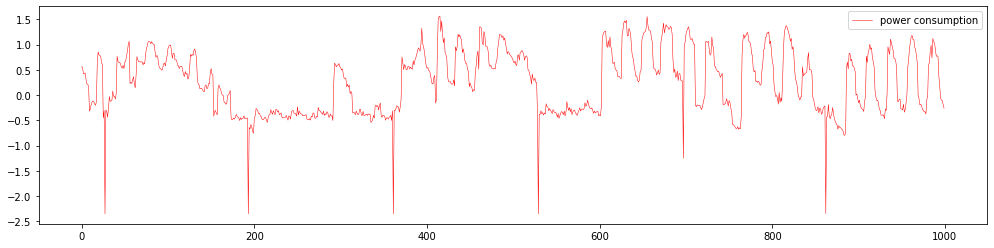

In [150]:
dfg = df_scaled[0:1000]


fig, ax = plt.subplots(1, 1,figsize=(17,4), squeeze=False)
ax[0,0].plot(dfg.index, dfg['KW'], lw=0.5, color='red', label='power consumption')
[ax[i,0].legend() for i in range(1)]
#[ax[i].set_xticks([]) for i in range(4)]
#[ax[i].set_yticks([]) for i in range(5)]

In [151]:
# stationary ? No
import statsmodels.api as sm
sm.tsa.stattools.adfuller(df_scaled)[1]

1.1515308779742693e-11

In [152]:
sm.tsa.stattools.kpss(df_scaled)[1]

0.01

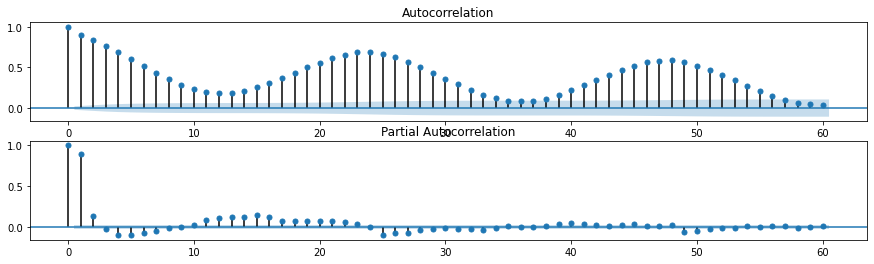

In [217]:
# ACF in blue, PACF in orange
# p = 2, q = 0 + seasonal effects
#
fig, ax = plt.subplots(2, 1, figsize=(15, 4), squeeze=False)
x = sm.graphics.tsa.plot_acf(df_scaled, lags=60, ax=ax[0,0])
x = sm.graphics.tsa.plot_pacf(df_scaled, lags=60, ax=ax[1,0])

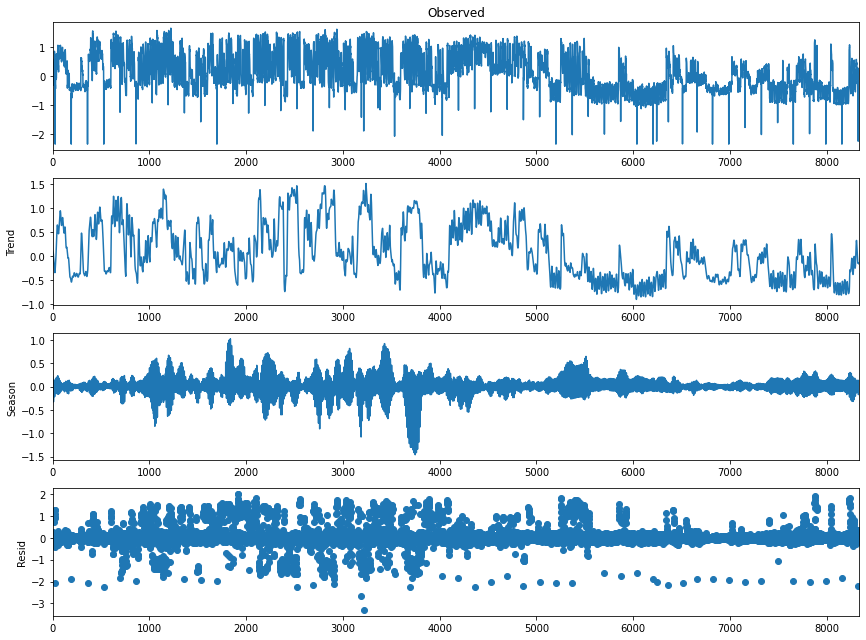

In [154]:
# we have a seasonal component here ...

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

plt.rc('figure',figsize=(12,9))
stl = STL(df_scaled, period=12, robust=True)
res = stl.fit()
fig = res.plot()

In [233]:
# Combine LOESS with ARIMA
stlf = STLForecast(df_scaled[0:6000], ARIMA, model_kwargs=dict(order=(2,0,0), trend="c"), period=7*24)

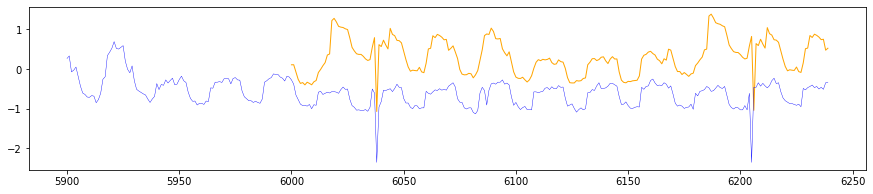

In [234]:
plt.rc('figure',figsize=(18,4))

#kws = df[0:2000].reset_index().drop(columns='timestamp')

stlf_res = stlf.fit()

forecast = stlf_res.forecast(240)

fig, ax = plt.subplots(plots, 1, figsize=(15,plots * 3), squeeze=False)
cnt = 0
ax[cnt,0].plot(forecast, color='orange', lw=1)
ax[cnt,0].plot(df_scaled[5900:6240], color='blue', lw=0.4)

In [235]:
print(stlf_res.summary())

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                 6000
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 943.419
Date:                Tue, 13 Oct 2020   AIC                          -1878.838
Time:                        20:01:55   BIC                          -1852.039
Sample:                             0   HQIC                         -1869.531
                               - 6000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2915      0.032      8.979      0.000       0.228       0.355
ar.L1          0.6865      0.006    111.990      0.000       0.674       0.698
ar.L2          0.2304      0.006     40.696      0.0

In [236]:
# Uh-oh - so our residuals show some autocorrelation

from statsmodels.stats.stattools import durbin_watson
durbin_watson(stlf_res.result.resid)

0.43496341232668456

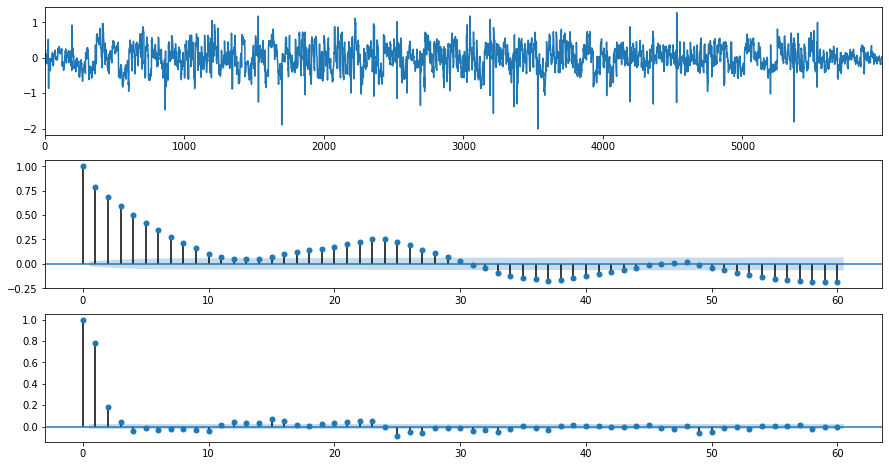

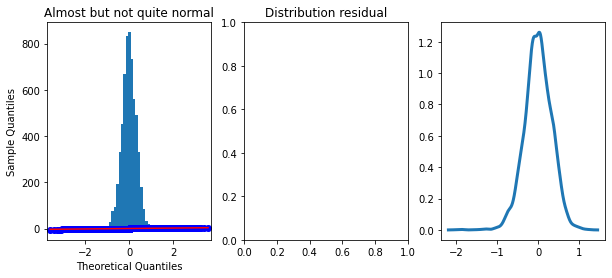

In [270]:
fig, ax = plt.subplots(3, 1, figsize=(15, 8), squeeze=False)
x = stlf_res.result.resid.plot(ax=ax[0,0])
x = sm.graphics.tsa.plot_acf(stlf_res.result.resid, lags=60, ax=ax[1,0])
ax[1,0].set_title('')
x = sm.graphics.tsa.plot_pacf(stlf_res.result.resid, lags=60, ax=ax[2,0])
ax[2,0].set_title('')

kde = sm.nonparametric.KDEUnivariate(stlf_res.result.resid)
kde.fit()

fig, ax = plt.subplots(1, 3, figsize=(10, 4), squeeze=False)
x = ax[0,0].hist(stlf_res.result.resid, bins=30)
ax[0,1].set_title('Distribution residual')
ax[0,2].plot(kde.support, kde.density, lw=3, label='kernel density', zorder=10)
ax[0,0].set_title('Almost but not quite normal')
x = qqplot(stlf_res.result.resid, line='q', ax=ax[0,0], fit=True)

In [255]:
import pyflux as pf

model = pf.ARIMA(data=df_scaled[0:6000], ar=2, ma=0, target='KW', family=pf.Normal())

In [256]:
x = model.fit("MLE")
x.summary()

Normal ARIMA(2,0,0)                                                                                       
======================================================= ==================================================
Dependent Variable: KW                                  Method: MLE                                       
Start Date: 2                                           Log Likelihood: -1287.8973                        
End Date: 5999                                          AIC: 2583.7946                                    
Number of observations: 5998                            BIC: 2610.5913                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0288     0.0042     6.7918   0.0      (0.0205 | 0.0372)        
AR(1)                                

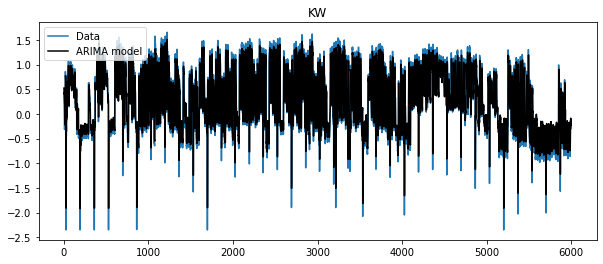

In [259]:
model.plot_fit(figsize=(10,4))

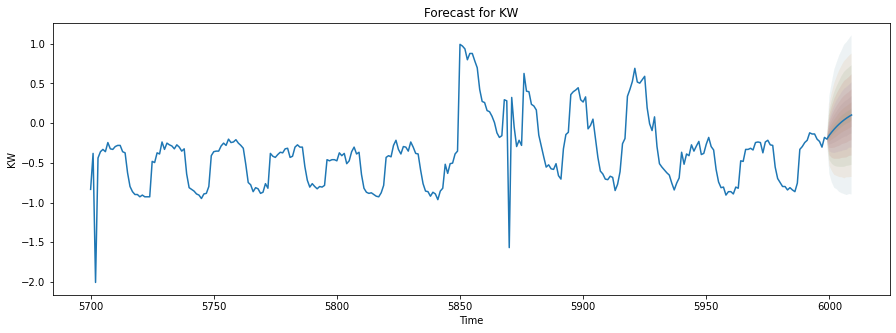

In [271]:
# Hmmm - I wouldn't have expected that
model.plot_predict(h=10,past_values=300,figsize=(15,5))

In [272]:
# looking for volatility

model = pf.GARCH(p=1, q=1, data=df_scaled[0:1500])

model.adjust_prior(1, pf.TruncatedNormal(0.01, 0.5, lower=0.0, upper=1.0))
model.adjust_prior(2, pf.TruncatedNormal(0.97, 0.5, lower=0.0, upper=1.0))

In [69]:
print(model.latent_variables)

Index    Latent Variable           Prior           Prior Hyperparameters     V.I. Dist  Transform 
======== ========================= =============== ========================= ========== ==========
0        Vol Constant              Normal          mu0: 0, sigma0: 3         Normal     exp       
1        q(1)                      TruncatedNormal mu0: 0.01, sigma0: 0.5    Normal     None      
2        p(1)                      TruncatedNormal mu0: 0.97, sigma0: 0.5    Normal     None      
3        Returns Constant          Normal          mu0: 0, sigma0: 3         Normal     None      


In [70]:
#
# MCMC made easy
#
x = model.fit('M-H', nsims=20000)

Acceptance rate of Metropolis-Hastings is 0.000325
Acceptance rate of Metropolis-Hastings is 0.026725
Acceptance rate of Metropolis-Hastings is 0.412725
Acceptance rate of Metropolis-Hastings is 0.303

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.3191875


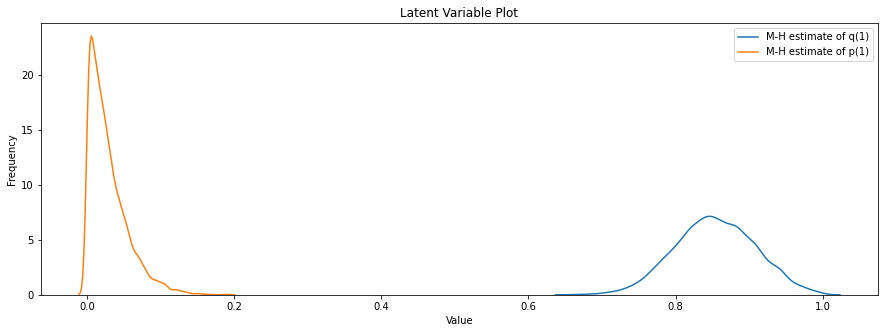

In [71]:
model.plot_z([1,2])

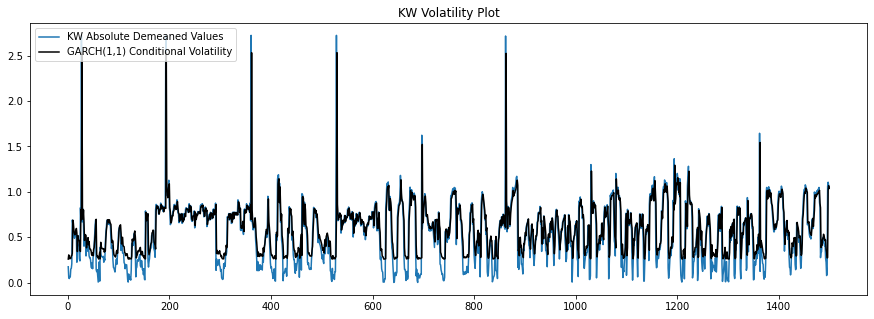

In [72]:
model.plot_fit(figsize=(15,5))

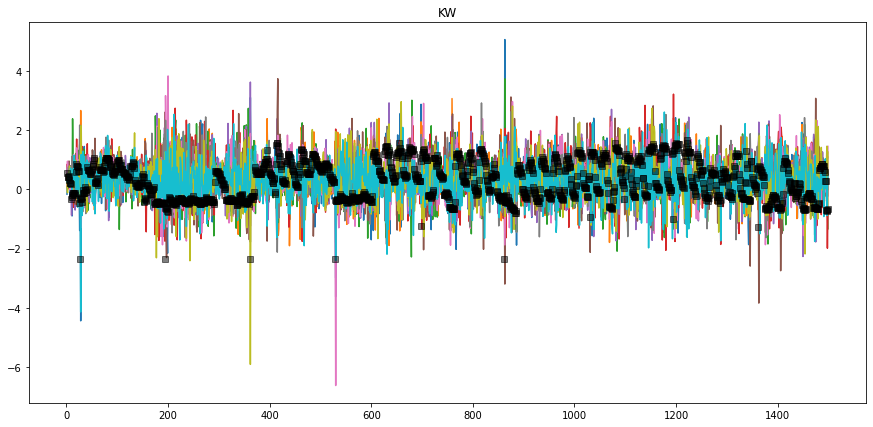

In [73]:
model.plot_sample(nsims=10, figsize=(15,7))

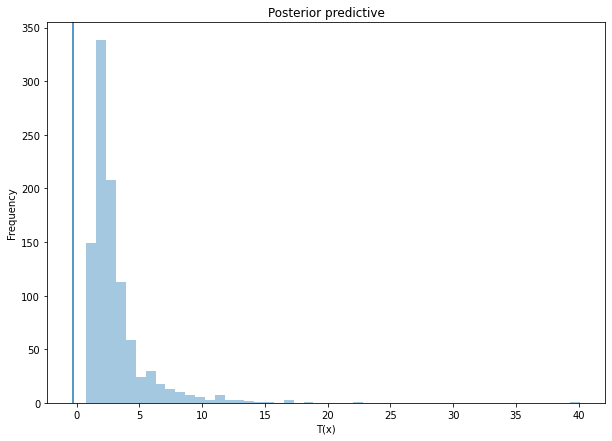

In [74]:
from scipy.stats import kurtosis
model.plot_ppc(T=kurtosis)

In [77]:
x.summary()

GARCH(1,1)                                                                                                
======================================================= ==================================================
Dependent Variable: KW                                  Method: Metropolis Hastings                       
Start Date: 1                                           Unnormalized Log Posterior: -1224.9757            
End Date: 1499                                          AIC: 2457.9514348468665                           
Number of observations: 1499                            BIC: 2479.201648839277                            
Latent Variable                          Median             Mean               95% Credibility Interval 
======================================== ================== ================== =========================
Vol Constant                             0.0653             0.0652             (0.0546 | 0.0775)        
q(1)                                     0.

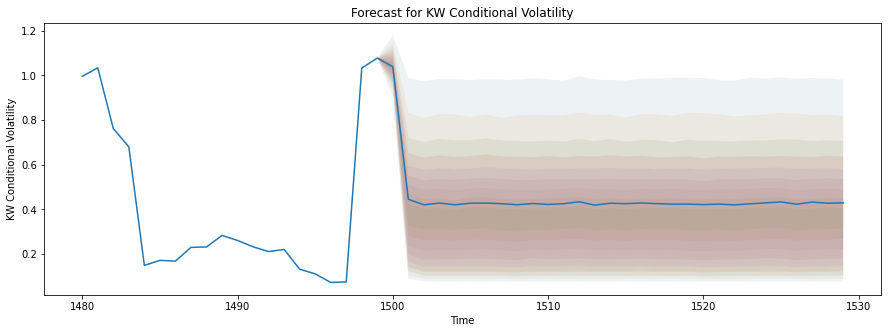

In [78]:
model.plot_predict(h=30, figsize=(15,5))